![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

# <a name="0">Machine Learning Accelerator - Tabular Data - Lecture 1</a>

## Final Project:  K Nearest Neighbors (KNN)

Build a [K Nearest Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to predict the __label__ field (substitute or not substitute) of the Amazon product substitute dataset.

### Final Project Problem: Product Substitute Prediction

__Problem Definition__:
Given a pair of products, (A, B), we say that B is a "substitute" for A if a customer would buy B in place of A -- say, if A were out of stock.

The goal of this project is to predict a substitute relationship between pairs of products. Complete the tasks in this notebook and submit your model's predictions as a CSV file to the leaderboard: __https://mlu.corp.amazon.com/contests/redirect/35__

1. <a href="#1">Read the datasets</a> (Given) 
2. <a href="#2">Data Processing</a> (Implement)
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a> (Suggested)
    * <a href="#23">Train - Validation - Test Datasets</a>
    * <a href="#24">Data Processing with Pipeline</a>
3. <a href="#3">Train (and Tune) a Classifier on the Training Dataset</a> (Implement)
4. <a href="#3">Make Predictions on the Test Dataset</a> (Implement)
5. <a href="#4">Write the Test Predictions to a CSV file</a> (Given)


__Datasets and Files:__


* __training.csv__: Training data with product pair features and corresponding labels:
> - `ID:` ID of the record
> - `label:` Tells whether the key and candidate products are substitutes (1) or not (0).
> - `key_asin ...:` Key product ASIN features 
> - `cand_asin ...:` Candidate product ASIN features 


* __public_test_features.csv__: Test data with product pairs features __without__ labels:
> - `ID:` ID of the record
> - `key_asin ...:` Key product ASIN features 
> - `cand_asin ...:` Candidate product ASIN features 


* __metadata-dataset.xlsx__: Provides detailed information about all key_ and cand_ columns in the training and test sets. Try to select some useful features to include in the model, as not all of them are suitable. `|Region Id|MarketPlace Id|ASIN|Binding Code|binding_description|brand_code|case_pack_quantity|, ...`


* __Sample submission file:__ You can see a sample file: sample-submission.csv under data/final_project folder.

## 1. <a name="1">Read the datasets</a> (Given)
(<a href="#0">Go to top</a>)

Then, we read the __training__ and __test__ datasets into dataframes, using [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html). This library allows us to read and manipulate our data.

In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")
  
training_data = pd.read_csv('../../data/final_project/training.csv')
test_data = pd.read_csv('../../data/final_project/public_test_features.csv')

print('The shape of the training dataset is:', training_data.shape)
print('The shape of the test dataset is:', test_data.shape)

The shape of the training dataset is: (36803, 228)
The shape of the test dataset is: (15774, 227)


## 2. <a name="2">Data Processing</a> (Implement)
(<a href="#0">Go to top</a>) 

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the datasets.

In [3]:
training_data.head()

,ID,label,key_Region Id,key_MarketPlace Id,key_ASIN,key_Binding Code,key_binding_description,key_brand_code,key_case_pack_quantity,key_classification_code,...,cand_pkg_weight,cand_pkg_weight_uom,cand_pkg_width,cand_release_date_embargo_level,cand_dw_creation_date,cand_dw_last_updated,cand_is_deleted,cand_last_updated,cand_version,cand_external_testing_certification
0,34016,0,1,1,B00YCZ6IKA,kitchen,Kitchen,NICLW,NaN,base_product,...,0.529104,pounds,5.118110,NaN,18-Apr-13,14-Oct-17,N,13-Oct-17,2867,NaN
1,3581,0,1,1,B00U25WT7A,office_product,Office Product,NaN,NaN,base_product,...,0.100000,pounds,4.500000,NaN,19-May-16,21-Mar-18,N,20-Mar-18,65,NaN
2,36025,1,1,1,B011BZ3GXU,consumer_electronics,Electronics,NaN,NaN,base_product,...,0.654773,pounds,3.937008,NaN,10-Dec-15,16-Feb-18,N,15-Feb-18,1532,NaN
3,42061,1,1,1,B0089XDG3I,pc,Personal Computers,NaN,NaN,base_product,...,3.549442,pounds,10.314961,NaN,19-Oct-12,15-Feb-18,N,14-Feb-18,13964,NaN
4,14628,1,1,1,B014UTSBZW,miscellaneous,Misc.,ZUKC7,1.0,base_product,...,0.396832,pounds,5.196850,NaN,26-Jul-12,9-Mar-18,N,9-Mar-18,1253,NaN


In [4]:
test_data.head()

,ID,key_Region Id,key_MarketPlace Id,key_ASIN,key_Binding Code,key_binding_description,key_brand_code,key_case_pack_quantity,key_classification_code,key_classification_description,...,cand_pkg_weight,cand_pkg_weight_uom,cand_pkg_width,cand_release_date_embargo_level,cand_dw_creation_date,cand_dw_last_updated,cand_is_deleted,cand_last_updated,cand_version,cand_external_testing_certification
0,35057,1,1,B0096M8VR2,pc,Personal Computers,NaN,1.0,base_product,Base Product,...,0.925932,pounds,5.826772,NaN,10-Apr-13,5-Jul-16,N,4-Jul-16,699,NaN
1,41573,1,1,B00EAQJCWW,kitchen,Kitchen,BUNN9,2.0,base_product,Base Product,...,NaN,NaN,NaN,NaN,17-Mar-16,17-Mar-16,N,17-Mar-16,2,NaN
2,44029,1,1,B013P93YOQ,toy,Toy,NaN,NaN,base_product,Base Product,...,NaN,NaN,NaN,NaN,23-Dec-15,2-Dec-17,N,2-Dec-17,17,NaN
3,6462,1,1,B00SKJPKGW,wireless_phone_accessory,Wireless Phone Accessory,PIQ22,1.0,base_product,Base Product,...,6.250000,pounds,9.700000,NaN,22-Jan-15,18-Jan-17,N,18-Jan-17,25351,NaN
4,17533,1,1,B001DCEKXM,sports,Sports,SUUNR,1.0,base_product,Base Product,...,0.176368,pounds,3.228346,NaN,4-Jan-11,16-Nov-17,N,16-Nov-17,7424,NaN


The shape of the training dataset is: (36803, 228)
The shape of the test dataset is: (15774, 227)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36803 entries, 0 to 36802
Columns: 228 entries, ID to cand_external_testing_certification
dtypes: float64(90), int64(12), object(126)
memory usage: 64.0+ MB

Test data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15774 entries, 0 to 15773
Columns: 227 entries, ID to cand_external_testing_certification
dtypes: float64(88), int64(11), object(128)
memory usage: 27.3+ MB

Training data description:
                 ID         label  key_Region Id  key_MarketPlace Id  \
count  36803.000000  36803.000000        36803.0             36803.0   
mean   26341.493438      0.505095            1.0                 1.0   
std    15159.339391      0.499981            0.0                 0.0   
min        1.000000      0.000000            1.0                 1.0   
25%    13250.500000      0.000000            1.0              

Matplotlib is building the font cache; this may take a moment.


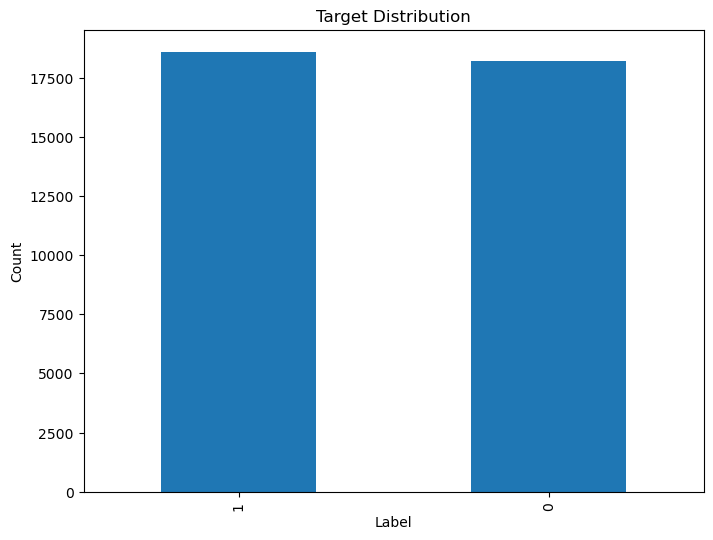

In [5]:
# Implement more EDA here
print('The shape of the training dataset is:', training_data.shape)
print('The shape of the test dataset is:', test_data.shape)

print("\nTraining data info:")
training_data.info()

print("\nTest data info:")
test_data.info()

print("\nTraining data description:")
print(training_data.describe())

print("\nTest data description:")
print(test_data.describe())

# Check for missing values
print("\nMissing values in training data:")
print(training_data.isnull().sum())

print("\nMissing values in test data:")
print(test_data.isnull().sum())

# Check target distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
training_data['label'].value_counts().plot.bar()
plt.title('Target Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### 2.2 <a name="22">Select features to build the model</a> 
(<a href="#2">Go to Data Processing</a>)

For a quick start, we recommend using only a few of the numerical features for both key_ and cand_ ASINs: __item_package_quantity__, __item_height__, __item_width__, __item_length__, __item_weight__, __pkg_height__, __pkg_width__, __pkg_length__, __pkg_weight__. Feel free to explore other fields from the metadata-dataset.xlsx file.


In [6]:
# Grab model features/inputs and target/output
numerical_features = ["key_item_package_quantity", 
                      "key_item_height", "key_item_width", "key_item_length", "key_item_weight", 
                      "key_pkg_height", "key_pkg_width", "key_pkg_length", "key_pkg_weight",
                      "cand_item_package_quantity", 
                      "cand_item_height", "cand_item_width", "cand_item_length", "cand_item_weight", 
                      "cand_pkg_height", "cand_pkg_width", "cand_pkg_length", "cand_pkg_weight"]

model_features = numerical_features
model_target = 'label'

### 2.3 <a name="23">Train - Validation Datasets</a>
(<a href="#2">Go to Data Processing</a>)

We already have training and test datasets, however the test dataset is missing the labels - the goal of the project is to predict these labels and submit them to leaderboard to get scored. 

To produce a validation set to evaluate model performance before submitting to the leaderboard, split the training dataset into train and validation subsets using sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. Validation data you get here will be used later in section 3 to tune your classifier.

In [7]:
# Implement here
from sklearn.model_selection import train_test_split

X = training_data[model_features]
y = training_data[model_target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Train set shape: (29442, 18)
Validation set shape: (7361, 18)


### 2.4 <a name="24">Data processing with Pipeline</a>
(<a href="#2">Go to Data Processing</a>)

Build a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)  to impute the missing values and scale the numerical features, and finally train a [K Nearest Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)  on the imputed and scaled dataset. 


In [8]:
# Implement here
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

def create_pipeline(n_neighbors):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier(n_neighbors=n_neighbors))
    ])

## 3. <a name="3">Train (and Tune) a Classifier</a> (Implement)
(<a href="#0">Go to top</a>)

Train and tune the [K Nearest Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) pipeline. The __"Model Tuning"__ section of the __MLA-TAB-Lecture1-KNN.ipynb__ can be useful here. You can loop over different K values and check validation accuracy each time and select best performing K.

In [9]:
# Implement here
from sklearn.metrics import accuracy_score, classification_report

k_values = [3, 5, 7, 9, 11]
best_k = 0
best_accuracy = 0

for k in k_values:
    pipeline = create_pipeline(k)
    pipeline.fit(X_train, y_train)
    
    y_val_pred = pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    print(f"K = {k}, Validation Accuracy: {accuracy}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"\nBest K: {best_k}")
print(f"Best Validation Accuracy: {best_accuracy}")

K = 3, Validation Accuracy: 0.6030430648009781
K = 5, Validation Accuracy: 0.6099714712674909
K = 7, Validation Accuracy: 0.6148621111262057
K = 9, Validation Accuracy: 0.6147262600190192
K = 11, Validation Accuracy: 0.6140470044830866

Best K: 7
Best Validation Accuracy: 0.6148621111262057


## 4. <a name="4">Make Predictions on the Test Dataset</a> (Implement)
(<a href="#0">Go to top</a>)

Use the trained classifier to predict the labels on the test set. Test accuracy would be displayed upon a valid submission to the leaderboard.

In [10]:
# Implement here

# Get test data to test the classifier
# ! test data should come from public_test_features.csv !
# ...

# Use the trained model to make predictions on the test dataset
# test_predictions = ...

final_pipeline = create_pipeline(best_k)
final_pipeline.fit(X, y)  # Train on all training data

# 4. Make Predictions on the Test Dataset (Implement)
X_test = test_data[model_features]
test_predictions = final_pipeline.predict(X_test)

print("\nTest Predictions:")
print(test_predictions[:10])  # Print first 10 predictions

# Print classification report for validation set
y_val_pred = final_pipeline.predict(X_val)
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))


Test Predictions:
[1 0 0 1 0 0 0 0 1 1]

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      3637
           1       0.70      0.76      0.73      3724

    accuracy                           0.72      7361
   macro avg       0.72      0.72      0.72      7361
weighted avg       0.72      0.72      0.72      7361



## 5. <a name="5">Write the test predictions to a CSV file</a> (Given)
(<a href="#0">Go to top</a>)

Use the following code to write the test predictions to a CSV file. Download locally the CSV file from the SageMaker instance, and upload it to __https://mlu.corp.amazon.com/contests/redirect/35__

In [11]:
import pandas as pd

result_df = pd.DataFrame(columns=["ID", "label"])
result_df["ID"] = test_data["ID"].tolist()
result_df["label"] = test_predictions

result_df.to_csv("../../data/project_day1_result.csv", index=False)

In [12]:
print('Double-check submission file against the sample_submission.csv')
sample_submission_df = pd.read_csv('../../data/final_project/sample-submission.csv')
print('Differences between project_day1_result IDs and sample submission IDs:',(sample_submission_df['ID'] != result_df['ID']).sum())

Double-check submission file against the sample_submission.csv
Differences between project_day1_result IDs and sample submission IDs: 0
